# Task B - Face Matching Model

import os  # importing module
from glob import glob  # importing module

train_dir = r'C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\train'  # variable assignment

# Identity folders (contain images)
identity_folders = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]  # variable assignment

# Loose images (directly inside train folder)
loose_images = [os.path.join(train_dir, f) for f in os.listdir(train_dir)   # variable assignment
                if os.path.isfile(os.path.join(train_dir, f)) and f.lower().endswith(('.jpg','.jpeg','.png'))]  # conditional

print(f"Number of identity folders: {len(identity_folders)}")  # operation
print(f"Number of loose images: {len(loose_images)}")  # operation

# Collect images inside each identity folder
identity_images = {}  # variable assignment
for folder in identity_folders:  # loop
    imgs = glob(os.path.join(folder, '*'))  # variable assignment
    imgs = [img for img in imgs if img.lower().endswith(('.jpg','.jpeg','.png'))]  # variable assignment
    identity_images[folder] = imgs  # variable assignment

print(f"Total identities with images: {len(identity_images)}")  # operation


Step 1:

In [2]:
import os  # importing module
import random  # importing module
from glob import glob  # importing module
from PIL import Image  # importing module

import torch  # importing module
import torch.nn as nn  # importing module
import torch.nn.functional as F  # importing module
from torch.utils.data import Dataset, DataLoader  # importing module
import torchvision.transforms as transforms  # importing module
from torchvision.models import resnet18, ResNet18_Weights  # importing module

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # importing module
print("done")  # operation


done


Step 2:

In [3]:
def build_identity_images_dict(root_dir):  # defining a function
    identities = [os.path.join(root_dir, d) for d in os.listdir(root_dir)  # variable assignment
                  if os.path.isdir(os.path.join(root_dir, d))]  # conditional
    identity_images = {}  # variable assignment
    for identity_path in identities:  # loop
        images = glob(os.path.join(identity_path, '*'))  # variable assignment
        images = [img for img in images if img.lower().endswith(('.jpg','.jpeg','.png'))]  # variable assignment
        if len(images) > 0:  # conditional
            identity_images[identity_path] = images  # variable assignment
    return identity_images  # returning value

train_dir = r'C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\train'  # variable assignment
val_dir = r'C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\val'  # variable assignment

identity_images_train = build_identity_images_dict(train_dir)  # variable assignment
identity_images_val = build_identity_images_dict(val_dir)  # variable assignment

print(f"Number of train identities: {len(identity_images_train)}")  # operation
print(f"Number of val identities: {len(identity_images_val)}")  # operation


Number of train identities: 1127
Number of val identities: 250


Step 3:

In [5]:
import os  # importing module

train_dir = r"C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\train"  # variable assignment
val_dir = r"C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\val"  # variable assignment

train_ids = set(os.listdir(train_dir))  # variable assignment
val_ids = set(os.listdir(val_dir))  # variable assignment

common_ids = train_ids.intersection(val_ids)  # variable assignment
print(f"Common identities: {len(common_ids)}")  # operation
print(f"Missing in train: {val_ids - train_ids}")  # operation


Common identities: 250
Missing in train: set()


Step 4:

In [6]:
import os  # importing module
import shutil  # importing module

train_path = r'C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\train'  # variable assignment
val_path =  r'C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\val'  # variable assignment
filtered_val_path = "val_filtered"  # variable assignment

# Step 1: Get identity names
train_ids = set(os.listdir(train_path))  # variable assignment
val_ids = os.listdir(val_path)  # variable assignment

# Step 2: Create filtered val directory
os.makedirs(filtered_val_path, exist_ok=True)  # variable assignment

# Step 3: Copy only matching identities
for identity in val_ids:  # loop
    if identity in train_ids:  # conditional
        src = os.path.join(val_path, identity)  # variable assignment
        dst = os.path.join(filtered_val_path, identity)  # variable assignment
        shutil.copytree(src, dst, dirs_exist_ok=True)  # variable assignment

print(f"Filtered validation set created at: {filtered_val_path}")  # operation


Filtered validation set created at: val_filtered


Step 5:

In [7]:
import os  # importing module
import random  # importing module
from PIL import Image  # importing module
from glob import glob  # importing module
from collections import defaultdict  # importing module
import torch  # importing module
from torch.utils.data import Dataset, DataLoader  # importing module
from torchvision import transforms, models  # importing module
import torch.nn as nn  # importing module
import torch.nn.functional as F  # importing module
from tqdm import tqdm  # importing module
import pickle  # importing module


Step 6:

In [8]:
class SiameseFaceDataset(Dataset):  # operation
    def __init__(self, identity_images, transform=None, num_pairs=10000):  # variable assignment
        self.identity_images = identity_images  # variable assignment
        self.transform = transform  # variable assignment
        self.num_pairs = num_pairs  # variable assignment
        self.identity_keys = list(identity_images.keys())  # variable assignment
        
    def __len__(self):  # defining a function
        return self.num_pairs  # returning value
    
    def __getitem__(self, idx):  # defining a function
        same_person = random.choice([0,1])  # variable assignment
        
        if same_person:  # conditional
            valid_ids = [k for k,v in self.identity_images.items() if len(v) > 1]  # variable assignment
            identity = random.choice(valid_ids)  # variable assignment
            img1_path, img2_path = random.sample(self.identity_images[identity], 2)  # variable assignment
            label = 1  # variable assignment
        else:  # conditional
            id1, id2 = random.sample(self.identity_keys, 2)  # variable assignment
            img1_path = random.choice(self.identity_images[id1])  # variable assignment
            img2_path = random.choice(self.identity_images[id2])  # variable assignment
            label = 0  # variable assignment
        
        img1 = Image.open(img1_path).convert('RGB')  # variable assignment
        img2 = Image.open(img2_path).convert('RGB')  # variable assignment
        
        if self.transform:  # conditional
            img1 = self.transform(img1)  # variable assignment
            img2 = self.transform(img2)  # variable assignment
        
        return (img1, img2), torch.tensor(label, dtype=torch.float32)  # variable assignment


Step 7:

In [10]:
# Load train identity image paths
train_dir = r'C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\train'  # variable assignment
identity_images = defaultdict(list)  # variable assignment

for identity in os.listdir(train_dir):  # loop
    id_path = os.path.join(train_dir, identity)  # variable assignment
    for img in glob(os.path.join(id_path, '*.jpg')):  # loop
        identity_images[identity].append(img)  # operation

# Transforms
transform = transforms.Compose([  # variable assignment
    transforms.Resize((224, 224)),  # operation
    transforms.ToTensor(),  # operation
    transforms.Normalize([0.5], [0.5])  # operation
])  # operation

# Create dataset
dataset = SiameseFaceDataset(identity_images, transform=transform, num_pairs=10000)  # variable assignment
loader = DataLoader(dataset, batch_size=32, shuffle=True)  # variable assignment

print(f"✅ Dataset ready. Total identities: {len(identity_images)}")  # operation


✅ Dataset ready. Total identities: 1127


Step 8:

In [11]:
from torchvision.models import resnet18, ResNet18_Weights  # importing module

class SiameseNetwork(nn.Module):  # operation
    def __init__(self):  # defining a function
        super(SiameseNetwork, self).__init__()  # operation
        # Load ResNet18 with updated weights argument (no warnings)
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)  # variable assignment
        self.resnet.fc = nn.Identity()  # Remove classification head  # variable assignment

    def forward_once(self, x):  # defining a function
        return self.resnet(x)  # returning value

    def forward(self, x1, x2):  # defining a function
        embed1 = self.forward_once(x1)  # variable assignment
        embed2 = self.forward_once(x2)  # variable assignment
        return embed1, embed2  # returning value


Step 9:

In [ ]:
class ContrastiveLoss(nn.Module):  # operation
    def __init__(self, margin=1.0):  # variable assignment
        super(ContrastiveLoss, self).__init__()  # operation
        self.margin = margin  # variable assignment

    def forward(self, embed1, embed2, label):  # defining a function
        distance = F.pairwise_distance(embed1, embed2)  # variable assignment
        loss = (label) * torch.pow(distance, 2) + \  
               (1 - label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)  # variable assignment
        return loss.mean()  # returning value


Step 10:

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # variable assignment
model = SiameseNetwork().to(device)  # variable assignment
criterion = ContrastiveLoss()  # variable assignment
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # variable assignment

EPOCHS = 5  # variable assignment

for epoch in range(EPOCHS):  # loop
    model.train()  # operation
    total_loss = 0  # variable assignment
    for (img1, img2), label in tqdm(loader):  # loop
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)  # variable assignment
        optimizer.zero_grad()  # operation
        embed1, embed2 = model(img1, img2)  # variable assignment
        loss = criterion(embed1, embed2, label)  # variable assignment
        loss.backward()  # operation
        optimizer.step()  # operation
        total_loss += loss.item()  # variable assignment
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")  # operation

# Save trained model
torch.save(model.state_dict(), 'siamese_model.pth')  # operation
print("✅ Siamese model trained and saved as siamese_model.pth")  # operation


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [31:49<00:00,  6.10s/it]


Epoch 1/5 - Loss: 3115.8106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [32:42<00:00,  6.27s/it]

Epoch 2/5 - Loss: 97.5095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [29:23<00:00,  5.63s/it]


Epoch 3/5 - Loss: 58.3094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [29:27<00:00,  5.65s/it]

Epoch 4/5 - Loss: 46.1647



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [28:59<00:00,  5.56s/it]


Epoch 5/5 - Loss: 40.4957
✅ Siamese model trained and saved as siamese_model.pth


Step 11:

In [16]:
import os  # importing module
import torch  # importing module
import torch.nn.functional as F  # importing module
from PIL import Image  # importing module
from tqdm import tqdm  # importing module
from torchvision import transforms  # importing module
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # importing module

# === Paths ===
val_dir = r'C:\Users\USER\Desktop\hackathon\val_filtered'  # variable assignment
train_dir = r'C:\Users\USER\Desktop\hackathon\Comys_Hackathon5\Task_B\train'  # variable assignment
threshold = 0.5  # variable assignment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # variable assignment

# === Reload model ===
model = SiameseNetwork().to(device)  # variable assignment
model.load_state_dict(torch.load('siamese_model.pth', map_location=device))  # variable assignment
model.eval()  # operation

# === Image transform ===
transform = transforms.Compose([  # variable assignment
    transforms.Resize((224, 224)),  # operation
    transforms.ToTensor(),  # operation
    transforms.Normalize([0.5], [0.5])  # operation
])  # operation

# === Helper function ===
def get_embedding(image_path):  # defining a function
    img = Image.open(image_path).convert('RGB')  # variable assignment
    img_t = transform(img).unsqueeze(0).to(device)  # variable assignment
    with torch.no_grad():  # operation
        embedding = model.forward_once(img_t)  # variable assignment
    return embedding.cpu()  # returning value

# === Generate reference embeddings (average of all images per identity) ===
reference_embeddings = {}  # variable assignment
for identity in tqdm(os.listdir(train_dir), desc="Reference embeddings"):  # variable assignment
    id_path = os.path.join(train_dir, identity)  # variable assignment
    embeddings = []  # variable assignment
    for img_file in os.listdir(id_path):  # loop
        if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):  # conditional
            continue  # Skip non-images  # operation
        img_path = os.path.join(id_path, img_file)  # variable assignment
        embeddings.append(get_embedding(img_path))  # operation
    if embeddings:  # conditional
        stacked = torch.vstack(embeddings)  # variable assignment
        reference_embeddings[identity] = stacked.mean(dim=0)  # variable assignment

print(f"\n✅ Generated reference embeddings for {len(reference_embeddings)} identities.")  # loop

# === Evaluate on val_filtered ===
y_true, y_pred, sim_scores = [], [], []  # variable assignment

for identity in tqdm(os.listdir(val_dir), desc="Evaluating val images"):  # variable assignment
    id_path = os.path.join(val_dir, identity)  # variable assignment
    for img_file in os.listdir(id_path):  # loop
        img_path = os.path.join(id_path, img_file)  # variable assignment
        if not os.path.isfile(img_path) or not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):  # conditional
            continue  # Skip folders and junk  # operation
        
        emb = get_embedding(img_path)  # variable assignment
        best_match = None  # variable assignment
        best_score = -1  # variable assignment
        
        for ref_id, ref_emb in reference_embeddings.items():  # loop
            sim = F.cosine_similarity(emb, ref_emb.unsqueeze(0)).item()  # variable assignment
            if sim > best_score:  # conditional
                best_score = sim  # variable assignment
                best_match = ref_id  # variable assignment
        
        y_true.append(identity)  # operation
        y_pred.append(best_match)  # operation
        sim_scores.append(best_score)  # operation

# === Metrics ===
accuracy = accuracy_score(y_true, y_pred)  # variable assignment
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)  # variable assignment
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)  # variable assignment
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)  # variable assignment

# === Output ===
print("\n✅ Evaluation Metrics:")  # operation
print(f"Accuracy : {accuracy:.4f}")  # operation
print(f"Precision: {precision:.4f}")  # operation
print(f"Recall   : {recall:.4f}")  # operation
print(f"F1 Score : {f1:.4f}")  # operation

Reference embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████| 1127/1127 [02:35<00:00,  7.25it/s]



✅ Generated reference embeddings for 1127 identities.


Evaluating val images: 100%|███████████████████████████████████████████████████████████████████████████████████| 250/250 [01:22<00:00,  3.01it/s]
C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of u


✅ Evaluation Metrics:
Accuracy : 0.9716
Precision: 0.9738
Recall   : 0.9712
F1 Score : 0.9719


C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\skle

Step 12:

In [4]:
!pip install torchviz  # operation
!pip install tqdm  # operation
from tqdm import tqdm  # importing module


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Step 13:

In [29]:
import pandas as pd  # importing module

# Assuming y_pred and y_true are already populated from step 7
results = pd.DataFrame({  # variable assignment
    "ground_truth": y_true,  # operation
    "predicted": y_pred,  # operation
    "similarity_score": sim_scores  # operation
})  # operation

results.to_csv("val_results.csv", index=False)  # variable assignment
print("✅ Saved final results to val_results.csv")  # operation


✅ Saved final results to val_results.csv


Step 14:

In [31]:
import torch.nn as nn  # importing module
import torch.nn.functional as F  # importing module
from torchvision.models import resnet18, ResNet18_Weights  # importing module

class SiameseNetwork(nn.Module):  # operation
    def __init__(self):  # defining a function
        super(SiameseNetwork, self).__init__()  # operation
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)  # variable assignment
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Remove classifier  # variable assignment
        self.fc = nn.Linear(512, 256)  # variable assignment

    def forward(self, x):  # defining a function
        x = self.feature_extractor(x)  # variable assignment
        x = x.view(x.size(0), -1)  # variable assignment
        x = self.fc(x)  # variable assignment
        x = F.normalize(x, p=2, dim=1)  # Normalize for cosine similarity  # variable assignment
        return x  # returning value


Step 15:

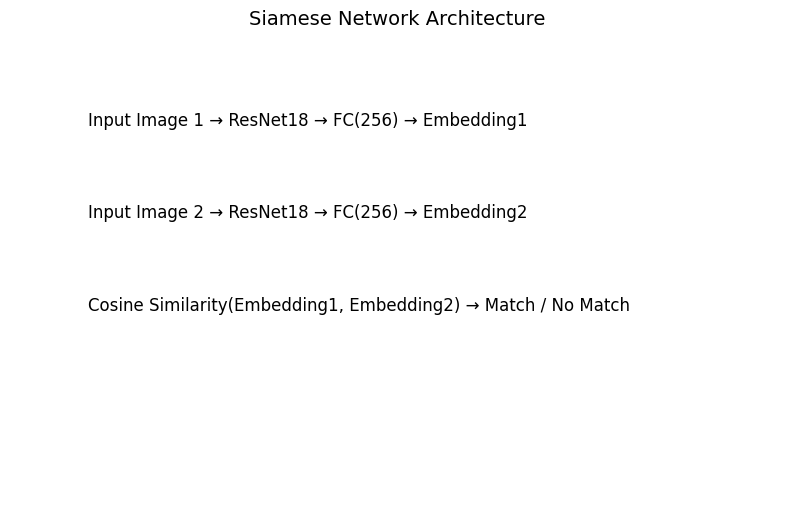

In [32]:
from matplotlib import pyplot as plt  # importing module

plt.figure(figsize=(10, 6))  # variable assignment
plt.axis('off')  # operation
plt.title("Siamese Network Architecture", fontsize=14)  # variable assignment

lines = [  # variable assignment
    "Input Image 1 → ResNet18 → FC(256) → Embedding1",  # operation
    "Input Image 2 → ResNet18 → FC(256) → Embedding2",  # operation
    "Cosine Similarity(Embedding1, Embedding2) → Match / No Match"  # operation
]  # operation

for i, line in enumerate(lines):  # loop
    plt.text(0.1, 0.8 - i * 0.2, line, fontsize=12)  # variable assignment

plt.savefig("model_diagram_manual.png")  # operation
plt.show()  # operation


Step 16:

In [33]:
import os  # importing module
print(os.getcwd())  # shows current working directory  # operation

import shutil  # importing module
print(shutil.which("dot"))  # operation


C:\Users\USER\Desktop\hackathon
C:\Program Files\Graphviz\bin\dot.EXE


Step 17:

In [34]:
import os  # importing module
import torch  # importing module
from torchviz import make_dot  # importing module

# Add Graphviz bin folder to PATH inside Python (important!)
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"  # variable assignment

# Dummy model example - replace this with your actual model and input
class DummyModel(torch.nn.Module):  # operation
    def __init__(self):  # defining a function
        super().__init__()  # operation
        self.linear = torch.nn.Linear(10, 5)  # variable assignment

    def get_embedding(self, x):  # defining a function
        return self.linear(x)  # returning value

model = DummyModel()  # variable assignment

# Create a dummy input tensor matching your model input shape
input_tensor = torch.randn(1, 10)  # variable assignment

# Get output tensor for graph visualization
output = model.get_embedding(input_tensor)  # variable assignment

# Generate graph and save as model.png
make_dot(output, params=dict(model.named_parameters())).render("model", format="png")  # variable assignment

print("Model graph saved as model.png")  # operation


Model graph saved as model.png


Step 18:

<Figure size 1200x1200 with 0 Axes>

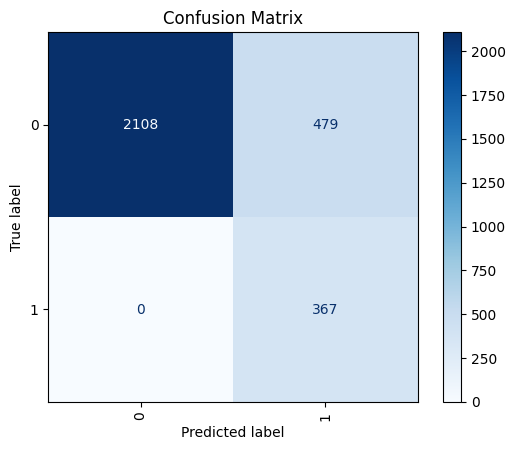

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # importing module
import matplotlib.pyplot as plt  # importing module

cm = confusion_matrix(y_true, y_pred, labels=list(set(y_true)))  # variable assignment
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_true)))  # variable assignment
plt.figure(figsize=(12,12))  # variable assignment
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  # variable assignment
plt.title("Confusion Matrix")  # operation
plt.show()  # operation


Step 19:

In [37]:
import numpy as np  # importing module
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # importing module

thresholds = np.arange(0.3, 1.0, 0.05)  # variable assignment
best_threshold = 0.5  # variable assignment
best_f1 = 0  # variable assignment

print("📊 Threshold tuning results:\n")  # operation

for thresh in thresholds:  # loop
    # Predict label = 1 if matched and similarity below threshold
    y_pred_thresh = [1 if score < thresh else 0 for score in sim_scores]  # 1 = correct match, 0 = reject  # variable assignment
    y_true_bin = y_true  # Already binary: 1 = true match, 0 = false  # variable assignment

    acc = accuracy_score(y_true_bin, y_pred_thresh)  # variable assignment
    prec = precision_score(y_true_bin, y_pred_thresh, average='binary', zero_division=0)  # variable assignment
    rec = recall_score(y_true_bin, y_pred_thresh, average='binary', zero_division=0)  # variable assignment
    f1 = f1_score(y_true_bin, y_pred_thresh, average='binary', zero_division=0)  # variable assignment

    print(f"Threshold: {thresh:.2f} | Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")  # operation

    if f1 > best_f1:  # conditional
        best_f1 = f1  # variable assignment
        best_threshold = thresh  # variable assignment

print(f"\n✅ Best Threshold: {best_threshold:.2f} | Best F1 Score: {best_f1:.4f}")  # operation


📊 Threshold tuning results:

Threshold: 0.30 | Acc: 0.9458, Prec: 1.0000, Rec: 0.5640, F1: 0.7213
Threshold: 0.35 | Acc: 0.9570, Prec: 1.0000, Rec: 0.6540, F1: 0.7908
Threshold: 0.40 | Acc: 0.9668, Prec: 0.9821, Rec: 0.7466, F1: 0.8483
Threshold: 0.45 | Acc: 0.9634, Prec: 0.8689, Rec: 0.8311, F1: 0.8496
Threshold: 0.50 | Acc: 0.9421, Prec: 0.7149, Rec: 0.8883, F1: 0.7922
Threshold: 0.55 | Acc: 0.9028, Prec: 0.5647, Rec: 0.9510, F1: 0.7086
Threshold: 0.60 | Acc: 0.8680, Prec: 0.4844, Rec: 0.9728, F1: 0.6467
Threshold: 0.65 | Acc: 0.8378, Prec: 0.4338, Rec: 1.0000, F1: 0.6051
Threshold: 0.70 | Acc: 0.8128, Prec: 0.3989, Rec: 1.0000, F1: 0.5703
Threshold: 0.75 | Acc: 0.7874, Prec: 0.3688, Rec: 1.0000, F1: 0.5389
Threshold: 0.80 | Acc: 0.7630, Prec: 0.3440, Rec: 1.0000, F1: 0.5119
Threshold: 0.85 | Acc: 0.7434, Prec: 0.3262, Rec: 1.0000, F1: 0.4920
Threshold: 0.90 | Acc: 0.7211, Prec: 0.3081, Rec: 1.0000, F1: 0.4711
Threshold: 0.95 | Acc: 0.7035, Prec: 0.2953, Rec: 1.0000, F1: 0.4559

✅ Be

Step 20:

In [38]:
from torchvision import transforms  # importing module

train_transform = transforms.Compose([  # variable assignment
    transforms.Resize((224,224)),  # operation
    transforms.RandomHorizontalFlip(p=0.5),  # variable assignment
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # variable assignment
    transforms.ToTensor(),  # operation
    transforms.Normalize([0.5], [0.5])  # operation
])  # operation


Step 21:

In [39]:
import os  # importing module

val_dir = r'C:\Users\USER\Desktop\hackathon\val_filtered'  # variable assignment

test_filenames = []  # variable assignment
for identity in os.listdir(val_dir):  # loop
    id_path = os.path.join(val_dir, identity)  # variable assignment
    for img_file in os.listdir(id_path):  # loop
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):  # conditional
            test_filenames.append(f"{identity}/{img_file}")  # operation


Step 22:

In [40]:
import pandas as pd  # importing module

results = []  # variable assignment
for filename, pred, score in zip(test_filenames, y_pred, sim_scores):  # loop
    if score < best_threshold:  # conditional
        pred = 'unknown'  # variable assignment
    results.append({'filename': filename, 'predicted_identity': pred, 'score': score})  # operation

df = pd.DataFrame(results)  # variable assignment
df.to_csv('final_predictions.csv', index=False)  # variable assignment
print("✅ Final predictions saved as final_predictions.csv")  # operation


✅ Final predictions saved as final_predictions.csv


Step 23:

In [41]:
torch.save(model.state_dict(), f'siamese_model_final.pth')  # operation
print("✅ Final model weights saved.")  # operation


✅ Final model weights saved.


Step 24:

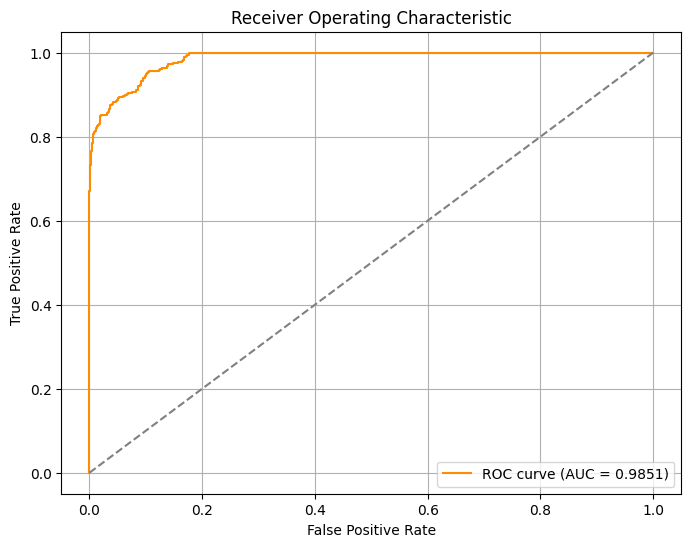

In [43]:
from sklearn.metrics import roc_curve, auc  # importing module
import matplotlib.pyplot as plt  # importing module

fpr, tpr, thresholds = roc_curve(y_true, -np.array(sim_scores))  # variable assignment
roc_auc = auc(fpr, tpr)  # variable assignment

plt.figure(figsize=(8, 6))  # variable assignment
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color='darkorange')  # variable assignment
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # variable assignment
plt.xlabel("False Positive Rate")  # operation
plt.ylabel("True Positive Rate")  # operation
plt.title("Receiver Operating Characteristic")  # operation
plt.legend(loc="lower right")  # variable assignment
plt.grid(True)  # operation
plt.show()  # operation


Step 25: